# Foundations of Machine Learning Frameworks Lab-10
Name: Devanshi Joshi   
Id: 8868052

In [224]:
# Importing the necessary libraries 
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import os
from collections import Counter
import shutil
import matplotlib.pyplot as plt

### Getting the data

In [225]:
data_folder = pathlib.Path('../../../dataset/birds_dataset')

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32, 
    label_mode='categorical')
validation_dataset = image_dataset_from_directory(
    data_folder / "valid",
    image_size=(180, 180),
    batch_size=32,
        label_mode='categorical')
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32,
        label_mode='categorical')

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


### Identifying the 3 classes with the highest number of images  

In [226]:
def MostImagesInClasses(dataset_directory):
    class_counts = Counter()
    for class_dir in os.listdir(dataset_directory):
        class_path = os.path.join(dataset_directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len(os.listdir(class_path))
    return class_counts

trainCounts = MostImagesInClasses(data_folder / "train")
testCounts = MostImagesInClasses(data_folder / "test")
validCounts = MostImagesInClasses(data_folder / "valid")

total_counts = trainCounts + testCounts + validCounts

top_classes = total_counts.most_common(3)
print(top_classes)

[('RUFOUS TREPE', 273), ('HOUSE FINCH', 258), ('D-ARNAUDS BARBET', 243)]


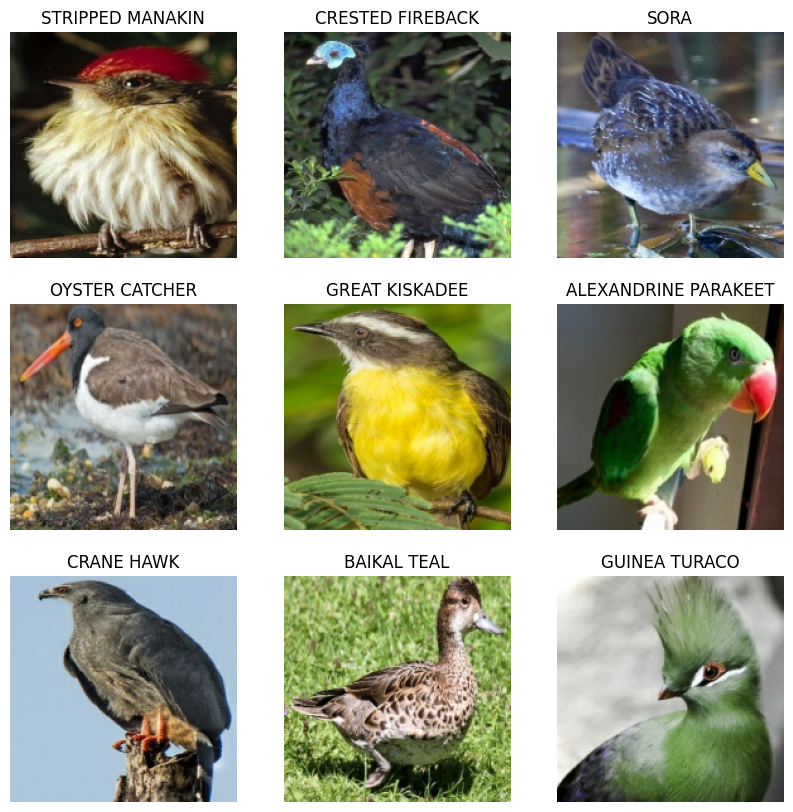

In [227]:
import matplotlib.pyplot as plt
import numpy as np

def show_batch(image_batch, label_batch, class_names):
    plt.figure(figsize=(10, 10))
    for n in range(9):
        ax = plt.subplot(3, 3, n + 1)
        plt.imshow(image_batch[n].numpy().astype("uint8"))
        label_index = np.argmax(label_batch[n])
        plt.title(class_names[label_index])
        plt.axis("off")

# Assuming `train_dataset` is your dataset
class_names = train_dataset.class_names

image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch, label_batch, class_names)


### Creating a new subset data directory containing only the images of the top 3 classes

In [229]:
def subset_top_classes(source_directory, destination_directory, top_classes):
    if not os.path.exists(destination_directory):
        os.makedirs(destination_directory)

    for class_name in top_classes:
        source_path = os.path.join(source_directory, class_name)
        destination_path = os.path.join(destination_directory, class_name)

        if os.path.exists(source_path):
            shutil.copytree(source_path, destination_path)
        else:
            print(f"Class {class_name} not found in {source_directory}")

new_data_folder = pathlib.Path('../../../dataset/birds_dataset_subset')

top_classes = ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET'] 

# Subset top classes from each partition
for partition in ['train', 'valid', 'test']:
    subset_top_classes(data_folder / partition, new_data_folder / partition, top_classes)


In [230]:
data_folder = pathlib.Path('../../../dataset/birds_dataset_subset')

train_dataset_subset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32, 
    label_mode='categorical')
validation_dataset_subset = image_dataset_from_directory(
    data_folder / "valid",
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical')
test_dataset_subset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32,
    label_mode='categorical')

Found 744 files belonging to 3 classes.
Found 15 files belonging to 3 classes.
Found 15 files belonging to 3 classes.


### Downloading the VGG16 Model without the head layers

In [231]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [232]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Freezing the weights of VGG16 model

In [233]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

### Data Augmentation

In [234]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomBrightness(0.3),
        layers.RandomContrast(0.1)
    ]
)

### Reviewing the augmented images

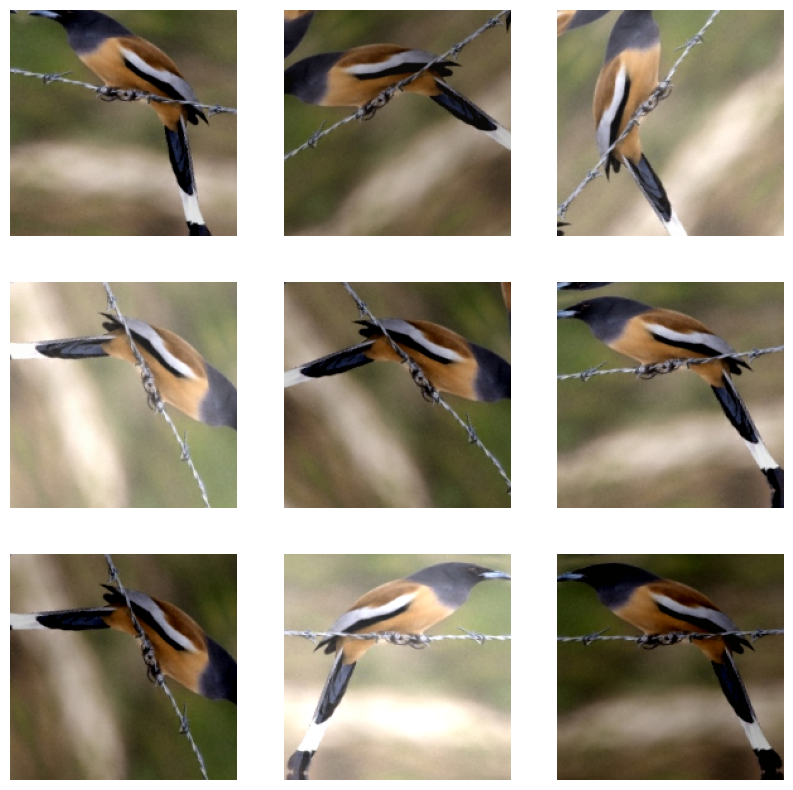

In [235]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset_subset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)  
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [236]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation='softmax')(x)  # 3 classes
model = keras.Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [237]:
model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_39 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 sequential_18 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem_19  (None, 180, 180, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_19 (TFOpLamb  (None, 180, 180, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0  

In [238]:
history = model.fit(
    train_dataset_subset, 
    epochs=15,  
    validation_data=validation_dataset_subset
)

Epoch 1/15


24/24 [==============================] - 102s 4s/step - loss: 1.1362 - accuracy: 0.8737 - val_loss: 1.4703 - val_accuracy: 0.9333
Epoch 2/15
24/24 [==============================] - 88s 4s/step - loss: 0.2500 - accuracy: 0.9597 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/15
24/24 [==============================] - 89s 4s/step - loss: 0.1639 - accuracy: 0.9731 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/15
24/24 [==============================] - 90s 4s/step - loss: 0.2332 - accuracy: 0.9812 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 5/15
24/24 [==============================] - 80s 3s/step - loss: 0.1191 - accuracy: 0.9839 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/15
24/24 [==============================] - 82s 3s/step - loss: 0.1476 - accuracy: 0.9852 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/15
24/24 [==============================] - 85s 4s/step - loss: 0.1342 - accuracy: 0.9839 - val_loss: 0.5396 - val_accuracy: 0.9333
Epoch 8/15

In [239]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [240]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history_fine = model.fit(
    train_dataset_subset, 
    epochs=8, 
    validation_data=validation_dataset_subset
)

Epoch 1/8


24/24 [==============================] - 112s 5s/step - loss: 0.0259 - accuracy: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/8
24/24 [==============================] - 110s 5s/step - loss: 0.0418 - accuracy: 0.9919 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/8
24/24 [==============================] - 112s 5s/step - loss: 0.0473 - accuracy: 0.9906 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/8
24/24 [==============================] - 218s 9s/step - loss: 0.0413 - accuracy: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/8
24/24 [==============================] - 373s 15s/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/8
24/24 [==============================] - 224s 9s/step - loss: 0.0325 - accuracy: 0.9919 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/8
24/24 [==============================] - 519s 22s/step - loss: 0.0369 - accuracy: 0.9933 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [241]:
test_loss, test_accuracy = model.evaluate(test_dataset_subset)
print(f"Test accuracy: {test_accuracy*100:.2f}%")

1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - accuracy: 1.0000
Test accuracy: 100.00%


In [242]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Get predictions
y_pred = model.predict(test_dataset_subset)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_dataset_subset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report (Precision, Recall, F1-Score)
print("Classification Report:\n", classification_report(y_true, y_pred_classes))


1/1 [==============================] - 2s 2s/step
Confusion Matrix:
 [[2 2 1]
 [1 1 3]
 [2 2 1]]
Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.20      0.20      0.20         5
           2       0.20      0.20      0.20         5

    accuracy                           0.27        15
   macro avg       0.27      0.27      0.27        15
weighted avg       0.27      0.27      0.27        15



Class 0 AUC: 0.47
Class 1 AUC: 0.34
Class 2 AUC: 0.39


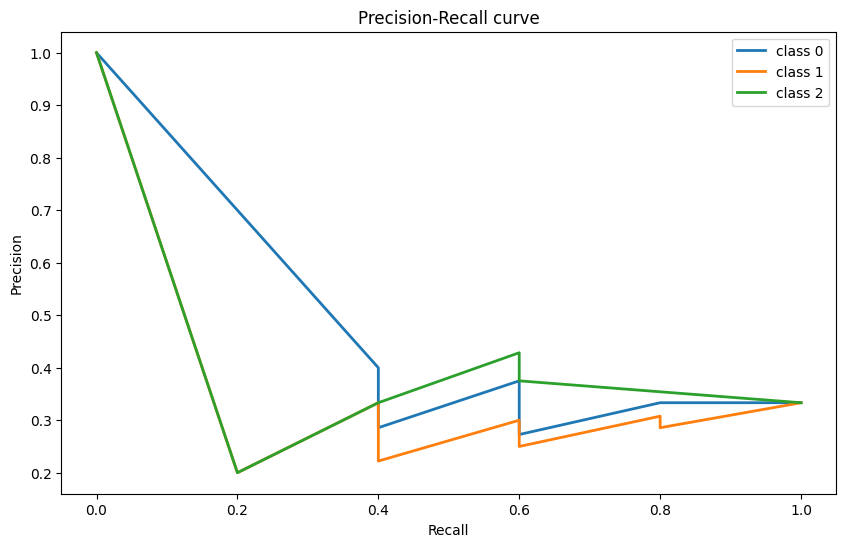

In [244]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Plotting precision-recall curve for each class
plt.figure(figsize=(10, 6))

for i in range(3):  # Adjust for the number of classes
    # Calculate precision and recall for each class
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    
    # Plot the precision-recall curve
    plt.plot(recall, precision, lw=2, label=f'class {i}')

    # Calculate the AUC
    auc_score = auc(recall, precision)
    print(f"Class {i} AUC: {auc_score:.2f}")

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="best")
plt.show()

In [245]:
def show_incorrect_predictions(image_batch, true_labels, pred_labels, class_names):
    incorrect = np.where(pred_labels != true_labels)[0]
    plt.figure(figsize=(10, 10))
    for i, idx in enumerate(incorrect[:9]):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[idx].numpy().astype("uint8"))
        plt.title(f"True: {class_names[true_labels[idx]]}, Pred: {class_names[pred_labels[idx]]}")
        plt.axis("off")

# Retrieving a batch of images and labels
for image_batch, label_batch in test_dataset_subset.take(1):
    true_labels = np.argmax(label_batch.numpy(), axis=1)
    pred_labels = np.argmax(model.predict(image_batch), axis=1)
    show_incorrect_predictions(image_batch, true_labels, pred_labels, class_names)


1/1 [==============================] - 2s 2s/step


<Figure size 1000x1000 with 0 Axes>

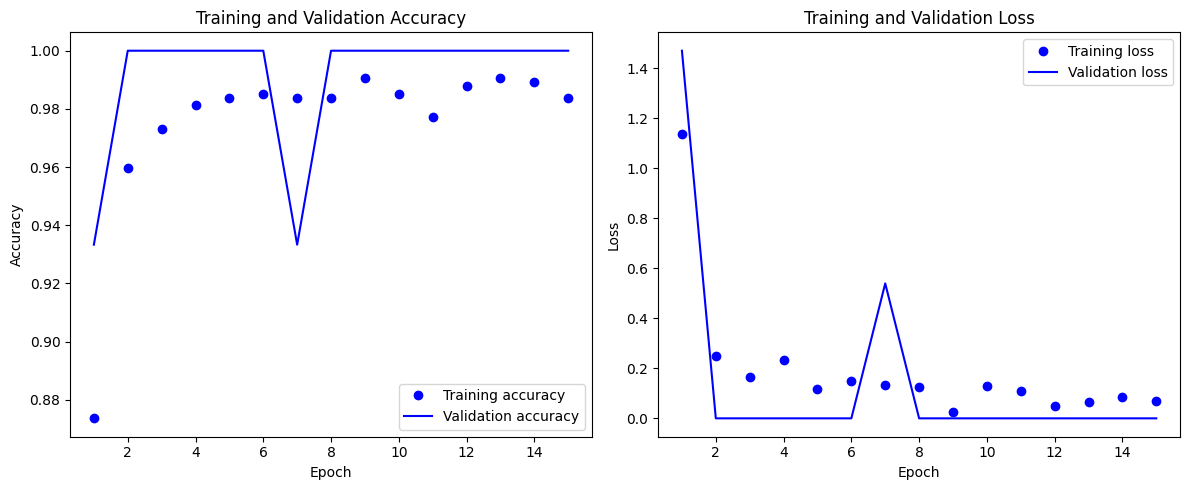

In [246]:
# Assuming `history` is the history object returned from model.fit
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Number of epochs - Adjust this based on how many epochs you used
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy per epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Observations:
**Precision-Recall Curve Observations:**   
- Significant diversity can be seen in the Precision-Recall curves for the three classes, indicating varying performance levels among the classes.
The ideal curve would be one that remained at the upper-right corner of the plot, however none of the curves exhibit this shape. This suggests that the model's performance could be enhanced.

**Training and Validation Accuracy/Loss Observations:**   
- Both the validation and training accuracy are extremely high, with the validation accuracy closely trailing the training accuracy. But considering the limited size of the dataset, this might indicate overfitting.
- Despite having a high accuracy rate, the validation loss graph's spikes imply that the model might not be generalising as well on the validation data. 

**Confusion Matrix and Classification Report Observations:**   
- Although the model's predictions across classes are reasonably balanced, as the confusion matrix demonstrates, its performance is poor due to the low true positive counts (main diagonal).
- The f1-scores also show that the recall and precision for each class are low. The f1-score provides a balance between recall and precision, and all of the numbers are poor in this instance.
- The model is not confident or reliable in its predictions for Class 1 and Class 2, as seen by their exceptionally poor precision and recall.
- The model's total accuracy is 27%, which is quite poor and indicates that the forecasts are frequently off.